In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn import model_selection
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
import PIL as pillow
import wordcloud
from operator import itemgetter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
import scikitplot as skplt

In [2]:
unordered = pd.read_csv('../part-02/cleaned_speeches_and_party.csv')

In [3]:
df = unordered[['speakers', 'person_id', 'debate_id', 'dates', 'constituency', 'party', 'headings', 'speeches']]
df.columns = ['mp', 'person_id', 'debate_id', 'date', 
   'constituency', 'party', 'topic', 'text']
df.head()

mp  person_id    debate_id        date       constituency  \
0  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
1  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
2  Lindsay Hoyle      10295  2020-01-07b  2020-01-07            Chorley   
3  Lindsay Hoyle      10295  2020-01-07b  2020-01-07            Chorley   
4     Mark Logan      25886  2020-01-07b  2020-01-07  Bolton North East   

          party                topic  \
0  Conservative                 None   
1  Conservative                 None   
2       Speaker  Speaker’s Statement   
3        Labour  Speaker’s Statement   
4  Conservative    Per Pupil Funding   

                                                text  
0  Let me finish the point. It takes five to 10 m...  
1  I will be brief; I just want to respond to a c...  
2  On behalf of the whole House, I wish to expres...  
3  On behalf of the whole House, I wish to expres...  
4  Whether he plans to increase the level of per ...

In [4]:
df.shape

(147438, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147438 entries, 0 to 147437
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   mp            147438 non-null  object
 1   person_id     147438 non-null  int64 
 2   debate_id     147438 non-null  object
 3   date          147438 non-null  object
 4   constituency  147438 non-null  object
 5   party         147438 non-null  object
 6   topic         147438 non-null  object
 7   text          147438 non-null  object
dtypes: int64(1), object(7)
memory usage: 9.0+ MB


In [5]:
df.columns

Index(['mp', 'person_id', 'debate_id', 'date', 'constituency', 'party',
       'topic', 'text'],
      dtype='object')

Our target variable is party, so let's begin by looking at the possible values.

In [43]:
df.party.unique()

array(['Conservative', 'Speaker', 'Labour', 'Liberal Democrat',
       'Scottish National Party', 'Labour/Co-operative', 'DUP',
       'Independent', 'Green', 'Plaid Cymru', 'Alliance',
       'Social Democratic and Labour Party', 'UUP', 'UKIP'], dtype=object)

In [44]:
df.party.value_counts()

Conservative                          85955
Labour                                32290
Scottish National Party               10171
Speaker                                6299
Labour/Co-operative                    5579
Liberal Democrat                       2722
DUP                                    2186
Independent                             800
Plaid Cymru                             719
Green                                   311
Social Democratic and Labour Party      231
UUP                                     129
UKIP                                     23
Alliance                                 23
Name: party, dtype: int64

We are not interested in the speaker so we can drop these rows, and for our purposes the Labour Co-Operative is the same as Labour (although seperate parties, they are included in Labour totals and are similarly centre-left) so we will re-label this class as Labour.

In [45]:
df = df.drop(df[df.party == 'Speaker'].index).reset_index(drop = True)

In [46]:
def losecoop(row):
    if row['party'] == 'Labour/Co-operative':
        return 'Labour'
    else:
        return row['party']

In [47]:
df.party = df.apply(losecoop, axis = 1)

Cleaning the text data and creating a word count column 

In [48]:
processed = df['text'].str.replace(r'^.+[^\.].*\.[a-z]{2,}$',' ')
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
processed = processed.str.replace(r'http',' ')
processed = processed.str.replace(r'£|\$', ' ')
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ')
processed = processed.str.replace(r'\d+(\.\d+)?', ' ')
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', ' ')
processed = processed.str.lower()
df['text'] = processed

In [49]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

In [50]:
df.head()

mp  person_id    debate_id        date       constituency  \
0  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
1  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
2  Lindsay Hoyle      10295  2020-01-07b  2020-01-07            Chorley   
3     Mark Logan      25886  2020-01-07b  2020-01-07  Bolton North East   
4    Sajid Javid      24854  2020-01-07b  2020-01-07         Bromsgrove   

          party                topic  \
0  Conservative                 None   
1  Conservative                 None   
2        Labour  Speaker’s Statement   
3  Conservative    Per Pupil Funding   
4  Conservative    Per Pupil Funding   

                                                text  word_count  
0  let me finish the point it takes five to minut...         140  
1  i will be brief i just want to respond to a co...         164  
2  on behalf of the whole house i wish to express...         339  
3  whether he plans to increase the level of per ...          11  
4  first mr speaker may i associate myself with t...          83

In [51]:
df[df.word_count <10].head()

mp  person_id    debate_id        date  \
52      Lindsay Hoyle      10295  2020-01-07b  2020-01-07   
53      Rachel Reeves      24851  2020-01-07b  2020-01-07   
54      Lindsay Hoyle      10295  2020-01-07b  2020-01-07   
255         Bill Cash      10095  2020-01-07b  2020-01-07   
275  Jonathan Edwards      24743  2020-01-07b  2020-01-07   

                    constituency         party  \
52                       Chorley        Labour   
53                    Leeds West        Labour   
54                       Chorley        Labour   
255                        Stone  Conservative   
275  Carmarthen East and Dinefwr   Independent   

                                       topic                             text  \
52                              Productivity            i call rachel reeves    
53                              Productivity               indicated dissent    
54                              Productivity  let us take somebody else then    
255  Saving of ECA for implementation period                  very very good    
275  Saving of ECA for implementation period                            rose    

     word_count  
52            4  
53            2  
54            6  
255           3  
275           1

We will drop all rows with less than 10 words as these will be of little use to our model. 

In [52]:
df = df.drop(df[df.word_count < 10].index).reset_index(drop = True)

In [53]:
df.word_count.max()

12954

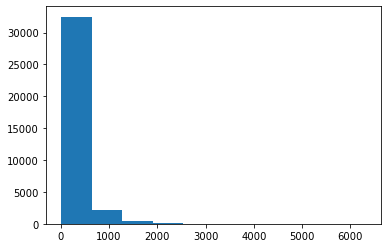

In [54]:
plt.hist(df[df.party == 'Labour'].word_count);

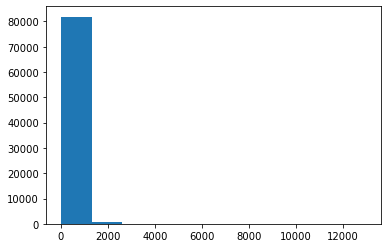

In [55]:
plt.hist(df[df.party == 'Conservative'].word_count);

Both Labour and Conservative word count distributions are right skewed. This is not surprising as the debates are relatively free flowing and will be back and forth conversation, so word count for each row of data is expected to be low, and most debates will follow a similar fashion.

In [56]:
df.shape

(133895, 9)

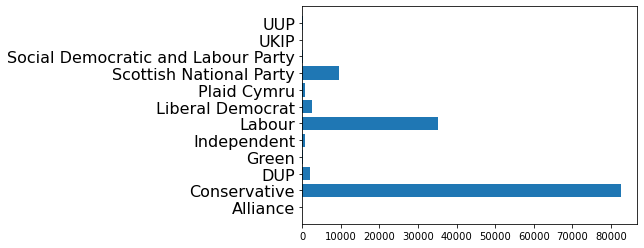

In [57]:
plt.barh(*np.unique(df.party, return_counts=True))

plt.yticks(fontsize=16)
plt.show()

We have a severe class imbalance so let us explore the data with an unsupervised model and see if all of our classes are significant or not. 

In [58]:
df.head()

mp  person_id    debate_id        date       constituency  \
0  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
1  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
2  Lindsay Hoyle      10295  2020-01-07b  2020-01-07            Chorley   
3     Mark Logan      25886  2020-01-07b  2020-01-07  Bolton North East   
4    Sajid Javid      24854  2020-01-07b  2020-01-07         Bromsgrove   

          party                topic  \
0  Conservative                 None   
1  Conservative                 None   
2        Labour  Speaker’s Statement   
3  Conservative    Per Pupil Funding   
4  Conservative    Per Pupil Funding   

                                                text  word_count  
0  let me finish the point it takes five to minut...         140  
1  i will be brief i just want to respond to a co...         164  
2  on behalf of the whole house i wish to express...         339  
3  whether he plans to increase the level of per ...          11  
4  first mr speaker may i associate myself with t...          83

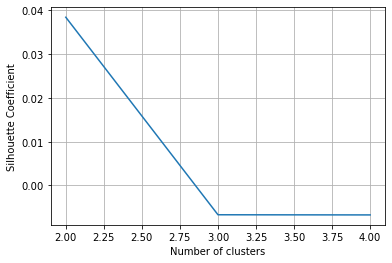

In [59]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
scaler = StandardScaler(with_mean=False)

vect = TfidfVectorizer(stop_words='english',max_features=10000)

#Cluster to see if there is inherent structure in the data - try for 2, 3, 4 clusters. See if the clusters are similar to the classes
def fit_plot_clusters(k_range,data):
    def fitcluster(k,data):
        TfIdfm=vect.fit_transform(data)
        X=scaler.fit_transform(TfIdfm)  
        km = KMeans(n_clusters=k, random_state=1)
        kfit=km.fit(X)
        #Silhouette Coefficient for each k
        score=metrics.silhouette_score(X, km.labels_)
        return kfit, score

    kfits=[]
    scores = []

    for k in k_range:
        kfit,score=fitcluster(k,data)
        kfits.append(kfit)
        scores.append(score)

    plt.plot(k_range, scores)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.grid(True)

#not good and gets worse as k increases
fit_plot_clusters([2,3,4],df['text'])




As we can see the silhouette coefficient was highest at 2 clusters. 

In [60]:
from scikitplot.cluster import plot_elbow_curve

In [61]:
TfIdfm=vect.fit_transform(df['text'])
X=scaler.fit_transform(TfIdfm) 

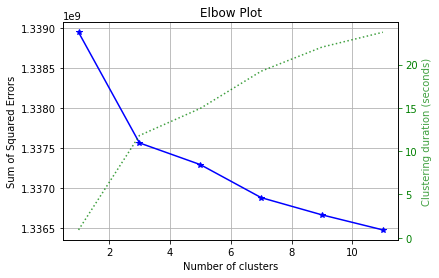

In [62]:
model = KMeans(n_clusters=2, random_state=1)

plot_elbow_curve(model, X)
plt.show()

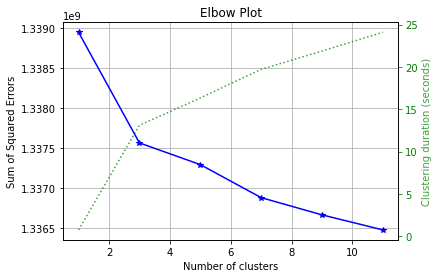

In [63]:
model = KMeans(n_clusters=3, random_state=1)

plot_elbow_curve(model, X)
plt.show()

The elbow plot indicates that 3 clusters may be optimal, although the silhouette coefficient was higher at 2 clusters. Either way, the smaller classes will be dropped and the dataset reduced to Conservatives, Labour and SNP.

It should be mentioned that the reason for having very little data from these parties is due to them not holding many seats in the House of Commons. Out of 650 seats the current allocation is as follows. 


In [64]:
parties = ['Conservative', 'Labour', 'Liberal Democrat', 'Scottish National Party', 'DUP',
           'Independent', 'Green', 'Plaid Cymru', 'Alliance']
seats = [364, 202, 11, 48, 8, 2, 1, 3, 1]
hoc_seats = pd.DataFrame(list(zip(parties, seats)), columns = ['Party', 'Seats'])
hoc_seats

Party  Seats
0             Conservative    364
1                   Labour    202
2         Liberal Democrat     11
3  Scottish National Party     48
4                      DUP      8
5              Independent      2
6                    Green      1
7              Plaid Cymru      3
8                 Alliance      1

In [65]:
df = df[(df.party == 'Conservative') | (df.party == 'Labour') | (df.party == 'Scottish National Party')].reset_index(drop = True)

In [66]:
df.party.value_counts(normalize = True)

Conservative               0.648980
Labour                     0.276583
Scottish National Party    0.074437
Name: party, dtype: float64

In [67]:
df.shape

(127235, 9)

In [68]:
df.head()

mp  person_id    debate_id        date       constituency  \
0  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
1  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
2  Lindsay Hoyle      10295  2020-01-07b  2020-01-07            Chorley   
3     Mark Logan      25886  2020-01-07b  2020-01-07  Bolton North East   
4    Sajid Javid      24854  2020-01-07b  2020-01-07         Bromsgrove   

          party                topic  \
0  Conservative                 None   
1  Conservative                 None   
2        Labour  Speaker’s Statement   
3  Conservative    Per Pupil Funding   
4  Conservative    Per Pupil Funding   

                                                text  word_count  
0  let me finish the point it takes five to minut...         140  
1  i will be brief i just want to respond to a co...         164  
2  on behalf of the whole house i wish to express...         339  
3  whether he plans to increase the level of per ...          11  
4  first mr speaker may i associate myself with t...          83

import plotly.express as px

In [69]:
fig = px.histogram(df, x='date', template='plotly_white', title='Number of speeches by date')
fig.update_xaxes(categoryorder='category descending', title='Date').update_yaxes(title='Number of individual speeches per date')
fig.show()

We can see that the amount of data collected over time varies greatly, with gaps in the data that line up with public holidays and certain peaks that correlate to key events. For example there is a recent peak between 15th March 2002 and 28th March 2020, during this time the UK began feeling the effects of the COVID 19 pandemic and went into lockdown. This will have been a busy time in the House of Commons. Similarly there is a peak mid October 2018, which was when the European Council met and the then Prime Minister Theresa May was attempting to negotiate Brexit terms. 

In [72]:
df.to_csv('tory_labour_snp.csv')

Time to look at the actual text data. We still have 127k rows of data so we can't just eyeball the raw data

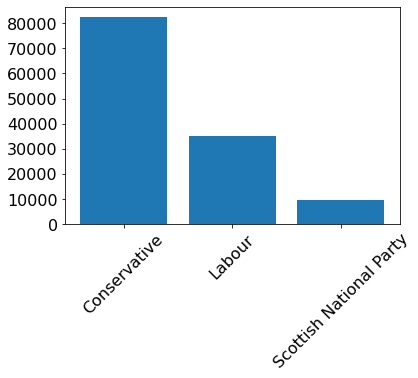

In [70]:
plt.bar(*np.unique(df.party, return_counts=True))
plt.xticks(range(3), 
           (df.party.unique()), 
           fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.show()

In [80]:
# Lets use the stop_words argument to remove words like "and, the, a"
cvec = CountVectorizer(stop_words= 'english')

# Fit our vectorizer using our train data
cvec.fit(df.text)

# Transform training data
cvec_mat = cvec.transform(df.text)

# words occuring
words = cvec.get_feature_names()
print(words[5000:5020])
print()
# number of different words
print(len(words))

['bethel', 'bethell', 'bethlehem', 'bethnal', 'betide', 'betjeman', 'betray', 'betrayal', 'betrayals', 'betrayed', 'betraying', 'betrays', 'bets', 'betsi', 'betsie', 'bett', 'better', 'bettered', 'betteridge', 'bettering']

59080


We have 59080 unique words in our dataset.

The following words are the most commonly occurring per class. 

In [81]:
from operator import itemgetter
def word_counter(mat):
    count = np.array(mat.sum(axis=0))[0]
    return count

def word_frequency_sorter(words, counts):
    sort_result = sorted(zip(words, list(counts)),
                         key=itemgetter(1), reverse=True)
    return sort_result

In [82]:
df_word_frequency = {}
for i,j in zip(range(len(df.party.unique())), df.party.unique()):
    csum_i = word_counter(cvec_mat[df.party == j, :])

    df_word_frequency[i] = pd.DataFrame(word_frequency_sorter(
        words, csum_i), columns=['word', 'frequency'])
    df_word_frequency[i].set_index('word', inplace=True)
    print(df.party.unique()[i])
    print(df_word_frequency[i].head(20))
    print()

Conservative
            frequency
word                 
hon             81765
government      42804
people          41617
right           41237
friend          39885
house           26866
work            24068
member          23395
need            19889
make            19866
support         19283
minister        19232
important       18619
new             18416
time            18236
uk              17762
want            16991
country         16948
members         16807
gentleman       16511

Labour
            frequency
word                 
government      36195
people          25995
hon             22816
minister        21843
house           15262
secretary       13961
member          13268
need            12314
state           12061
right           12058
time            11372
does            10527
friend          10159
said             9936
work             9731
just             9619
country          9525
members          9475
support          9352
new              9001

Scottish N

In [ ]:
LogisticRegression()

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = 1)

In [89]:
cvec = CountVectorizer(stop_words= 'english')

# Fit our vectorizer using our train data
cvec.fit(X_train)

# Transform training data
cvec_mat = cvec.transform(X_train)

In [90]:
X_train = cvec_mat
X_test = cvec.transform(X_test)

In [93]:
# Import and fit our logistic regression and test it, too
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
lr.fit(X_train, y_train)
lrtraining = lr.score(X_train, y_train)
lrcv = cross_val_score(lr, X_train, y_train).mean()
lrtest = lr.score(X_test, y_test)

print('training score ', lrtraining)
print('mean cross val training score ', lrcv)
print(' test score ', lrtest)

/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/alexdcruz/a

training score  0.8685997526879466
mean cross val training score  0.7698949879550474
 test score  0.7755037882360338


/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [94]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [97]:
docm(y_test, lr.predict(X_test), labels=df.party.unique())

p_Conservative  p_Labour  p_Scottish National Party
Conservative                      18600      1818                        225
Labour                             3332      5211                        255
Scottish National Party             833       678                        857

In [98]:
print(classification_report(y_test, lr.predict(
    X_test), target_names=df.party.unique()))

                         precision    recall  f1-score   support

           Conservative       0.82      0.90      0.86     20643
                 Labour       0.68      0.59      0.63      8798
Scottish National Party       0.64      0.36      0.46      2368

               accuracy                           0.78     31809
              macro avg       0.71      0.62      0.65     31809
           weighted avg       0.76      0.78      0.77     31809



In [100]:
from sklearn.pipeline import make_pipeline

In [102]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = 1)

In [104]:
model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      # sublinear_tf=True,
                                      max_df=0.3,
                                      max_features=400000
                                      ),
                      LogisticRegression(solver='lbfgs', multi_class='ovr'),
                      )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print("Number of features:", len(model.steps[0][1].get_feature_names()))

/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.771982772171398
Number of features: 54023


In [113]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [114]:
data_train, data_test, y_train, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = 1)

In [115]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='ovr'),
          DeciionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

tvec = TfidfVectorizer(stop_words='english',
                       # sublinear_tf=True,
                       max_df=0.5,
                       max_features=1000)

tvec.fit(data_train)
X_train = tvec.transform(data_train)
X_test = tvec.transform(data_test)

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    print()
    cm = docm(y_test, y_pred, df.party.unique())
    print(cm)
    res.append([model, score])
    print()
    print('-'*60)
    print()

KNeighborsClassifier()

0.5556289100569022

                         p_Conservative  p_Labour  p_Scottish National Party
Conservative                      13534      7040                         69
Labour                             4762      3990                         46
Scottish National Party            1344       874                        150

------------------------------------------------------------

LogisticRegression(multi_class='ovr')

0.7448835235310761

                         p_Conservative  p_Labour  p_Scottish National Party
Conservative                      18633      1856                        154
Labour                             4132      4581                         85
Scottish National Party            1066       822                        480

------------------------------------------------------------

DecisionTreeClassifier()

0.6662265396585872

                         p_Conservative  p_Labour  p_Scottish National Party
Conservative                    

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning:

"sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).



train time: 3.019s
test time:  0.006s
accuracy:   0.741
dimensionality: 1000
density: 1.000000
top 10 keywords per class:
Conservative: continue determined deliver delivering kingdom committed lady s...
Labour: manchester leader failure cut worse crisis failed secretary minister ...
Scottish National Party: correct nations benches constituent finally devolved...

classification report:
                         precision    recall  f1-score   support

           Conservative       0.77      0.91      0.84     20643
                 Labour       0.64      0.50      0.56      8798
Scottish National Party       0.63      0.14      0.24      2368

               accuracy                           0.74     31809
              macro avg       0.68      0.52      0.54     31809
           weighted avg       0.72      0.74      0.71     31809

confusion matrix:
[[18855  1640   148]
 [ 4384  4364    50]
 [ 1164   861   343]]

Perceptron
___________________________________________________________

train time: 1.037s
test time:  0.008s
accuracy:   0.736
dimensionality: 1000
density: 0.334667
top 10 keywords per class:
Conservative: delighted deliver continue kingdom closely committed shadow opp...
Labour: failure worse leader crisis told failed cut secretary minister cuts
Scottish National Party: minister debate week young brexit chancellor simply ...

classification report:
                         precision    recall  f1-score   support

           Conservative       0.76      0.93      0.84     20643
                 Labour       0.65      0.46      0.54      8798
Scottish National Party       0.78      0.06      0.12      2368

               accuracy                           0.74     31809
              macro avg       0.73      0.48      0.50     31809
           weighted avg       0.73      0.74      0.70     31809

confusion matrix:
[[19234  1389    20]
 [ 4757  4019    22]
 [ 1415   801   152]]

Elastic-Net penalty
_______________________________________________________

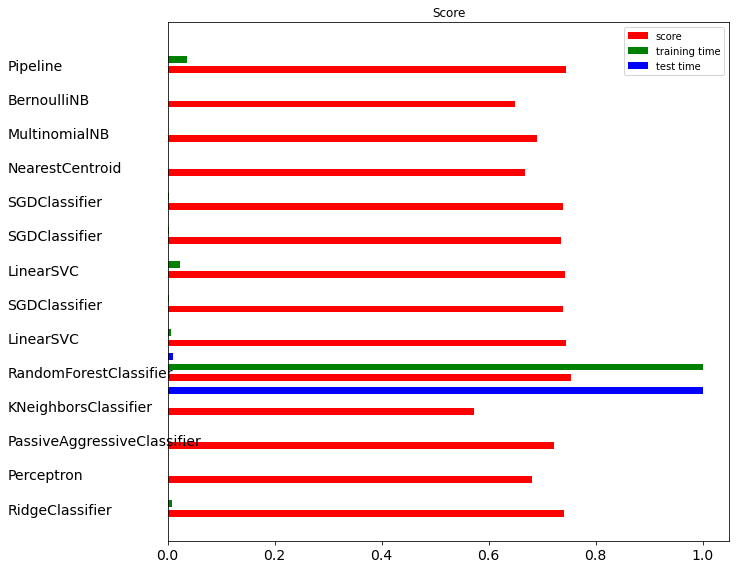

In [116]:
from time import time

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

feature_names = np.array(tvec.get_feature_names())


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers


def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(df.party.unique()):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print((trim("%s: %s"
                            % (category, " ".join(feature_names[top10])))))
        print()

    print("classification report:")
    print((metrics.classification_report(y_test, pred,
                                         target_names=df.party.unique())))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=1000, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=1000, tol=1e-3), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', LinearSVC(penalty="l2"))])))
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c, fontsize=14)

plt.show()

In [117]:
data_train, data_test, y_train, y_test = train_test_split(df.text, df.party, stratify = df.party, random_state = 1)

In [118]:
stop = stopwords.words('english')
stop = stop + ['conservative','conservatives','tory','tories','labour','corbyn', 'hon', 'friend', 'johnson', 'member', 'honerable', 'right']

In [119]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='ovr'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

tvec = TfidfVectorizer(stop_words= stop,
                       # sublinear_tf=True,
                       max_df=0.5,
                       max_features=1000)

tvec.fit(data_train)
X_train = tvec.transform(data_train)
X_test = tvec.transform(data_test)

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    print()
    cm = docm(y_test, y_pred, df.party.unique())
    print(cm)
    res.append([model, score])
    print()
    print('-'*60)
    print()

KNeighborsClassifier()

0.6450061303404697

                         p_Conservative  p_Labour  p_Scottish National Party
Conservative                      18446      2144                         53
Labour                             6830      1933                         35
Scottish National Party            1919       311                        138

------------------------------------------------------------

LogisticRegression(multi_class='ovr')



/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.7398849382250307

                         p_Conservative  p_Labour  p_Scottish National Party
Conservative                      18718      1763                        162
Labour                             4356      4359                         83
Scottish National Party            1171       739                        458

------------------------------------------------------------

DecisionTreeClassifier()

0.6525511647646892

                         p_Conservative  p_Labour  p_Scottish National Party
Conservative                      15838      3958                        847
Labour                             4048      4232                        518
Scottish National Party            1035       646                        687

------------------------------------------------------------

SVC()

0.7710710805118048

                         p_Conservative  p_Labour  p_Scottish National Party
Conservative                      19173      1374                         96
Labour     

In [121]:
res

[[KNeighborsClassifier(), 0.6450061303404697],
 [LogisticRegression(multi_class='ovr'), 0.7398849382250307],
 [DecisionTreeClassifier(), 0.6525511647646892],
 [SVC(), 0.7710710805118048],
 [RandomForestClassifier(), 0.745512276399761],
 [ExtraTreesClassifier(), 0.7373699267502908]]

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


/Users/alexdcruz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:556: UserWarning:

"sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).



train time: 3.740s
test time:  0.008s
accuracy:   0.735
dimensionality: 1000
density: 1.000000
top 10 keywords per class:
Conservative: deliver delighted continue course lady kingdom delivering commi...
Labour: manchester leader cut worse failure failed crisis secretary minister ...
Scottish National Party: wage nations benches finally constituent devolved br...

classification report:
                         precision    recall  f1-score   support

           Conservative       0.76      0.91      0.83     20643
                 Labour       0.63      0.48      0.54      8798
Scottish National Party       0.64      0.14      0.23      2368

               accuracy                           0.74     31809
              macro avg       0.68      0.51      0.53     31809
           weighted avg       0.72      0.74      0.71     31809

confusion matrix:
[[18881  1627   135]
 [ 4565  4185    48]
 [ 1254   787   327]]

Perceptron
___________________________________________________________

train time: 1.166s
test time:  0.007s
accuracy:   0.731
dimensionality: 1000
density: 0.330667
top 10 keywords per class:
Conservative: deliver course kingdom welcome continue lady closely committed ...
Labour: manchester worse failure crisis told failed cut secretary minister cuts
Scottish National Party: minister brexit debate must another simply governmen...

classification report:
                         precision    recall  f1-score   support

           Conservative       0.75      0.94      0.83     20643
                 Labour       0.65      0.43      0.52      8798
Scottish National Party       0.78      0.06      0.11      2368

               accuracy                           0.73     31809
              macro avg       0.73      0.47      0.48     31809
           weighted avg       0.72      0.73      0.69     31809

confusion matrix:
[[19339  1285    19]
 [ 5011  3769    18]
 [ 1471   762   135]]

Elastic-Net penalty
___________________________________________________

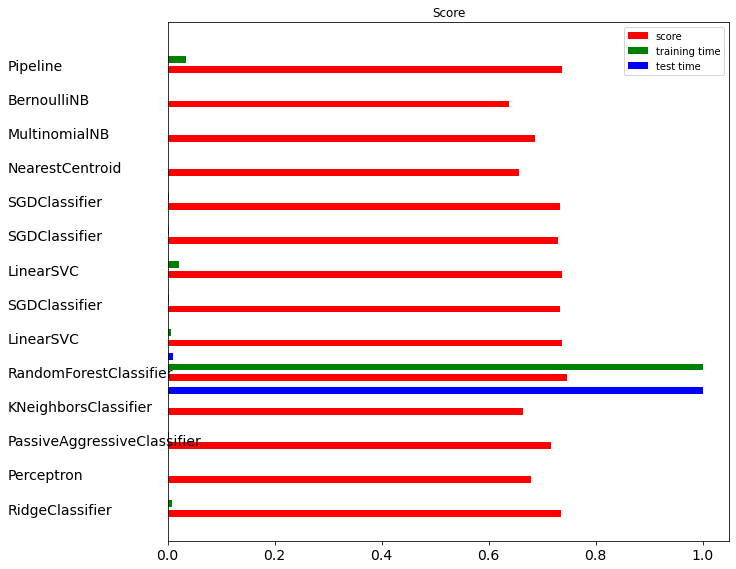

In [120]:
from time import time

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics

feature_names = np.array(tvec.get_feature_names())


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers


def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(df.party.unique()):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print((trim("%s: %s"
                            % (category, " ".join(feature_names[top10])))))
        print()

    print("classification report:")
    print((metrics.classification_report(y_test, pred,
                                         target_names=df.party.unique())))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=1000, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=1000, tol=1e-3), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classification', LinearSVC(penalty="l2"))])))
# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c, fontsize=14)

plt.show()

In [122]:
df.head()

mp  person_id    debate_id        date       constituency  \
0  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
1  Brandon Lewis      24879  2020-01-07a  2020-01-07     Great Yarmouth   
2  Lindsay Hoyle      10295  2020-01-07b  2020-01-07            Chorley   
3     Mark Logan      25886  2020-01-07b  2020-01-07  Bolton North East   
4    Sajid Javid      24854  2020-01-07b  2020-01-07         Bromsgrove   

          party                topic  \
0  Conservative                 None   
1  Conservative                 None   
2        Labour  Speaker’s Statement   
3  Conservative    Per Pupil Funding   
4  Conservative    Per Pupil Funding   

                                                text  word_count  
0  let me finish the point it takes five to minut...         140  
1  i will be brief i just want to respond to a co...         164  
2  on behalf of the whole house i wish to express...         339  
3  whether he plans to increase the level of per ...          11  
4  first mr speaker may i associate myself with t...          83

In [127]:
cvec = CountVectorizer(stop_words=stop)
X_train_cv = cvec.fit_transform(data_train)
X_test_cv = cvec.transform(data_test)

cvec_ngrams12 = CountVectorizer(stop_words=stop, ngram_range=(1,2))
X_train_n = cvec_ngrams12.fit_transform(data_train)
X_test_n = cvec_ngrams12.transform(data_test)

bvec = CountVectorizer(stop_words=stop, binary=True)
X_train_b = bvec.fit_transform(data_train)
X_test_b = bvec.transform(data_test)

tfidf = TfidfVectorizer(stop_words=stop)
X_train_t = tfidf.fit_transform(data_train)
X_test_t = tfidf.transform(data_test)

In [136]:
allmodels = []
allparams = []
allbestscores = []
alltestscores = []

In [131]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [148]:
model = LogisticRegression(solver = 'saga', max_iter = 100000)
params = {'C': np.logspace(-5, 5, 15),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False]}
gs = GridSearchCV(estimator = model,
                 param_grid = params, 
                 cv = 5,
                 n_jobs = -1
                 )
if __name__ == '__main__':
    gs.fit(X_train_cv, y_train)

best_params = gs.bast_params_
best_score = gs.best_score_
testscore =  gs.score(X_test_cv, y_test)
allmodels.append(gs.best_estimator_)
allparams.append(best_params)

print('best score ', best_score)
print('test score ', testscore)

predictions = pipeline.predict(X_test_cv)

print()
print(classification_report(y_test, predictions))

pd.DataFrame(confusion_matrix(y_test, predictions,
                              labels=y_test.unique()),
             columns=y_test.unique(),
             index=y_test.unique())

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words=stop)),
    ('logreg', LogisticRegression(solver = 'lbfgs'))]) 
params = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25], }
gs = GridSearchCV(pipeline,
                 params, 
                 cv = 5,
                 n_jobs = -1,
                 verbose = 1)

gs.fit(data_train, y_train)

best_params = gs.bast_params_
best_score = gs.best_score_
testscore =  gs.score(data_test, y_test)
allmodels.append(gs.best_estimator_)
allparams.append(best_params)

print('best score ', best_score)
print('test score ', testscore)

predictions = pipeline.predict(data_test)

print()
print(classification_report(y_test, predictions))

pd.DataFrame(confusion_matrix(y_test, predictions,
                              labels=y_test.unique()),
             columns=y_test.unique(),
             index=y_test.unique())